# **NLP project. Fake News detection** 

## **Basic imports** ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import common as cm
import torch

from transformers import DistilBertTokenizer
from transformers import DistilBertModel

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## **Loading datasets** ##

In [2]:
true = cm.load_data("True.csv")
true_short = cm.choose_random_part(true, 1000)
X_train_true, X_test_true, y_train_true, y_test_true = cm.divide_data_into_train_and_test(true_short, 0.2)

fake = cm.load_data("Fake.csv")
fake_short = cm.choose_random_part(fake, 1000)
X_train_fake, X_test_fake, y_train_fake, y_test_fake = cm.divide_data_into_train_and_test(fake_short, 0.2)

In [3]:
X_train = cm.merge_datasets(X_train_true, X_train_fake)
X_test = cm.merge_datasets(X_test_true, X_test_fake)
y_train = cm.merge_datasets(y_train_true, y_train_fake)
y_test = cm.merge_datasets(y_test_true, y_test_fake)

In [4]:
X_train, y_train = cm.shuffle_respectively(X_train, y_train)
X_test, y_test = cm.shuffle_respectively(X_test, y_test)

## **Preprocessing datasets** ##

Apart from clean_data() function that we defined in common.py, we have 3 methods of preprocessing the data:

1. Generate contextual word embeddings

2. Generate static word embeddings

3. Use lemmatization, stemmatization and create TF-IDF vector

Each of the above methods will be tested on several models and we can compare which model works the best on which type of preprocessing

In [ ]:
# Generate contextual word embeddings
def generate_features(X: pd.DataFrame) -> np.array:
    """
        Function that creates contextual word embeddings from input data using DistilBERT model
        :param X: ...
        :return: ...
    """
    # Loading DistilBERT model and tokenizer
    model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    # Tokenizing
    max_len = 512
    X['text'] = X['text'].apply((lambda x: x[:max_len]))
    tokenized = X['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # Padding
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    # Masking
    attention_mask = np.where(padded != 0, 1, 0)

    # Running sentences through BERT
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)

    # Output of DistilBERT will be input for Logistic Regression
    features = last_hidden_states[0][:,0,:].numpy()

    return features

def create_SWE(X):
    # TODO
    return

def create_TF_IDF(X):
    # TODO
    return

In [6]:
X_train_pre, y_train_pre = cm.clean_data(X_train, y_train)
X_test_pre, y_test_pre = cm.clean_data(X_test, y_test)

## **Necessary imports** ##

In [8]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [9]:
def display_metrics(model, y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels = model.classes_), display_labels=model.classes_)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

## **Aproach 1 - Contextual Word Embeddings** ##

In [7]:
X_train_features = generate_features(X_train_pre)
X_test_features = generate_features(X_test_pre)

### **Model 1 - SVM** ##

In [10]:
svm = SVC()
svm.fit(X_train_features, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

Accuracy: 0.945
F1 score: 0.945273631840796


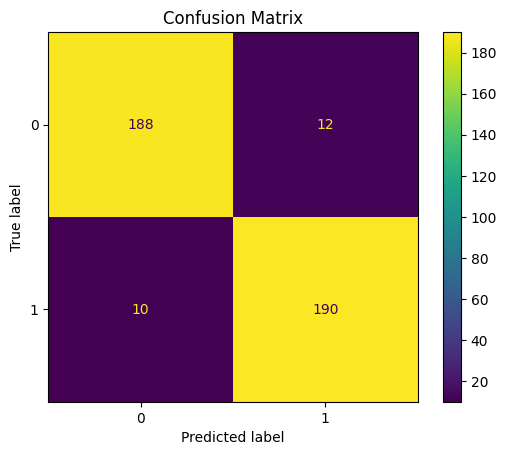

In [11]:
pred = svm.predict(X_test_features)
display_metrics(svm, y_test_pre, pred)

### **Model 2 - Logistic Regression**

In [12]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_features, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Accuracy: 0.9575
F1 score: 0.9576059850374065


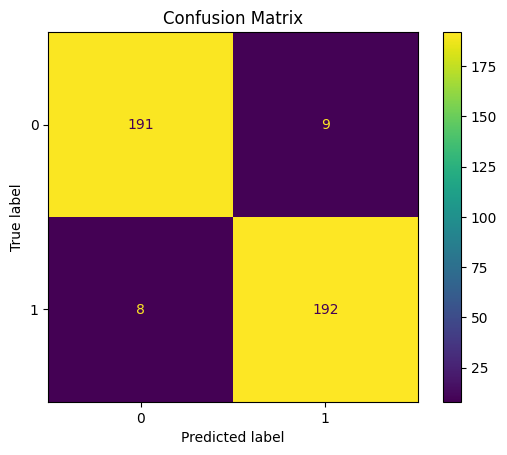

In [13]:
pred = lr_clf.predict(X_test_features)
display_metrics(lr_clf, y_test_pre, pred)

### **Model 3 - kNN**

In [14]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_features, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=10)

Accuracy: 0.92
F1 score: 0.9195979899497487


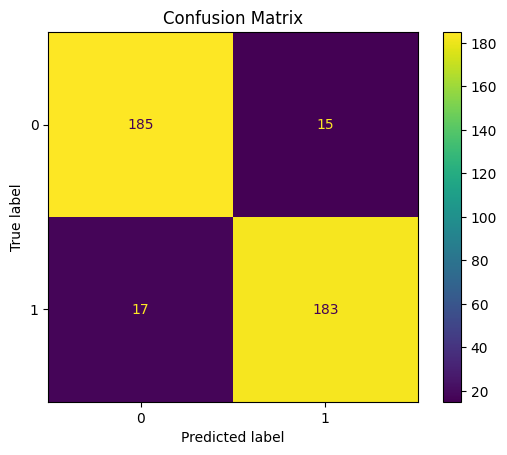

In [15]:
pred = knn.predict(X_test_features)
display_metrics(knn, y_test_pre, pred)

### **Model 4 - Decision Tree** ##

In [16]:
tree_clf = DecisionTreeClassifier(criterion="entropy")
tree_clf.fit(X_train_features, y_train_pre)

DecisionTreeClassifier(criterion='entropy')

Accuracy: 0.85
F1 score: 0.8522167487684729


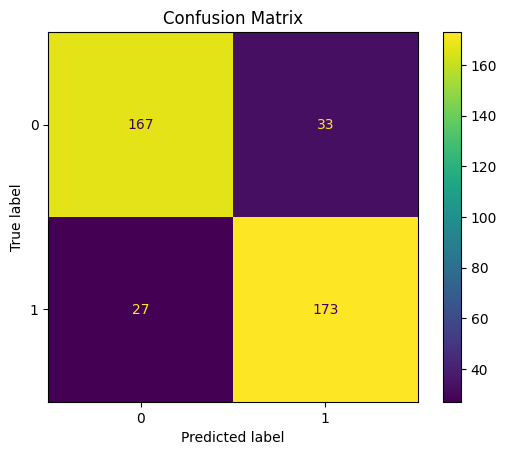

In [17]:
pred = tree_clf.predict(X_test_features)
display_metrics(tree_clf, y_test_pre, pred)

### **Model 5 - Random Forests** ##

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train_features, y_train_pre)

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

Accuracy: 0.92
F1 score: 0.9203980099502488


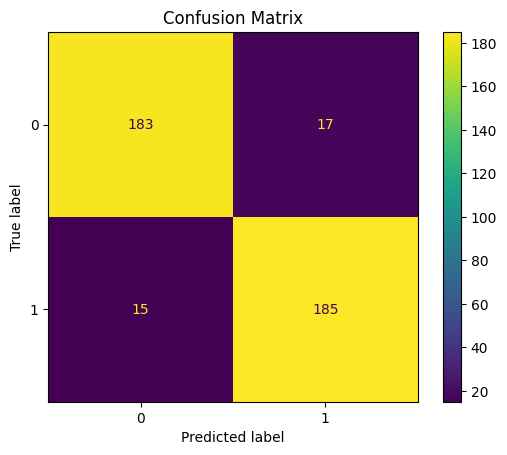

In [20]:
pred = rf.predict(X_test_features)
display_metrics(rf, y_test_pre, pred)

### **Model 6 - Neural Network**

In [21]:
...

Ellipsis

## **Approach 2 - Static Word Embeddings** ##

## **Approach 3 - TF-IDF vector** ##

## **Summary and comparison of the results** ##